# How to create branches for parallel node execution

LangGraph natively supports fan-out and fan-in using either regular edges or
[conditionalEdges](/langgraphjs/reference/classes/langgraph.StateGraph.html#addConditionalEdges).

This lets you run nodes in parallel to speed up your total graph execution.

Below are some examples showing how to add create branching dataflows that work
for you.

## Setup

First, install LangGraph.js

```bash
yarn add @langchain/langgraph @langchain/core
```

This guide will use OpenAI's GPT-4o model. We will optionally set our API key
for [LangSmith tracing](https://smith.langchain.com/), which will give us
best-in-class observability.


In [1]:
// process.env.OPENAI_API_KEY = "sk_...";

// Optional, add tracing in LangSmith
// process.env.LANGCHAIN_API_KEY = "ls__..."
// process.env.LANGCHAIN_CALLBACKS_BACKGROUND = "true";
process.env.LANGCHAIN_CALLBACKS_BACKGROUND = "true";
process.env.LANGCHAIN_TRACING_V2 = "true";
process.env.LANGCHAIN_PROJECT = "Branching: LangGraphJS";

Branching: LangGraphJS


## Fan out, fan in

First, we will make a simple graph that branches out and back in. When merging
back in, the state updates from all branches are applied by your **reducer**
(the `aggregate` method below).


In [2]:
import { END, START, StateGraph, Annotation } from "@langchain/langgraph";

const StateAnnotation = Annotation.Root({
  aggregate: Annotation<string[]>({
    reducer: (x, y) => x.concat(y),
  })
});

// Create the graph
const nodeA = (state: typeof StateAnnotation.State) => {
  console.log(`Adding I'm A to ${state.aggregate}`);
  return { aggregate: [`I'm A`] };
};
const nodeB = (state: typeof StateAnnotation.State) => {
  console.log(`Adding I'm B to ${state.aggregate}`);
  return { aggregate: [`I'm B`] };
};
const nodeC = (state: typeof StateAnnotation.State) => {
  console.log(`Adding I'm C to ${state.aggregate}`);
  return { aggregate: [`I'm C`] };
};
const nodeD = (state: typeof StateAnnotation.State) => {
  console.log(`Adding I'm D to ${state.aggregate}`);
  return { aggregate: [`I'm D`] };
};

const builder = new StateGraph(StateAnnotation)
  .addNode("a", nodeA)
  .addEdge(START, "a")
  .addNode("b", nodeB)
  .addNode("c", nodeC)
  .addNode("d", nodeD)
  .addEdge("a", "b")
  .addEdge("a", "c")
  .addEdge("b", "d")
  .addEdge("c", "d")
  .addEdge("d", END);

const graph = builder.compile();


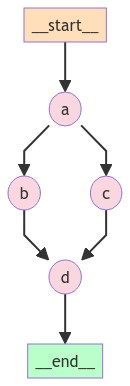

In [3]:
import * as tslab from "tslab";

const representation = graph.getGraph();
const image = await representation.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

In [4]:
// Invoke the graph
const baseResult = await graph.invoke({ aggregate: [] });
console.log("Base Result: ", baseResult);

Adding I'm A to 
Adding I'm B to I'm A
Adding I'm C to I'm A
Adding I'm D to I'm A,I'm B,I'm C
Base Result:  { aggregate: [ "I'm A", "I'm B", "I'm C", "I'm D" ] }


## Conditional Branching

If your fan-out is not deterministic, you can use
[addConditionalEdges](/langgraphjs/reference/classes/index.StateGraph.html#addConditionalEdges)
directly like this:


In [5]:
const ConditionalBranchingAnnotation = Annotation.Root({
  aggregate: Annotation<string[]>({
    reducer: (x, y) => x.concat(y),
  }),
  which: Annotation<string>({
    reducer: (x: string, y: string) => (y ?? x),
  })
})

// Create the graph
const nodeA2 = (state: typeof ConditionalBranchingAnnotation.State) => {
  console.log(`Adding I'm A to ${state.aggregate}`);
  return { aggregate: [`I'm A`] };
};
const nodeB2 = (state: typeof ConditionalBranchingAnnotation.State) => {
  console.log(`Adding I'm B to ${state.aggregate}`);
  return { aggregate: [`I'm B`] };
};
const nodeC2 = (state: typeof ConditionalBranchingAnnotation.State) => {
  console.log(`Adding I'm C to ${state.aggregate}`);
  return { aggregate: [`I'm C`] };
};
const nodeD2 = (state: typeof ConditionalBranchingAnnotation.State) => {
  console.log(`Adding I'm D to ${state.aggregate}`);
  return { aggregate: [`I'm D`] };
};
const nodeE2 = (state: typeof ConditionalBranchingAnnotation.State) => {
  console.log(`Adding I'm E to ${state.aggregate}`);
  return { aggregate: [`I'm E`] };
};

// Define the route function
function routeCDorBC(state: typeof ConditionalBranchingAnnotation.State): string[] {
  if (state.which === "cd") {
    return ["c", "d"];
  }
  return ["b", "c"];
}

const builder2 = new StateGraph(ConditionalBranchingAnnotation)
  .addNode("a", nodeA2)
  .addEdge(START, "a")
  .addNode("b", nodeB2)
  .addNode("c", nodeC2)
  .addNode("d", nodeD2)
  .addNode("e", nodeE2)
  // Add conditional edges
  // Third parameter is to support visualizing the graph
  .addConditionalEdges("a", routeCDorBC, ["b", "c", "d"])
  .addEdge("b", "e")
  .addEdge("c", "e")
  .addEdge("d", "e")
  .addEdge("e", END);

const graph2 = builder2.compile();


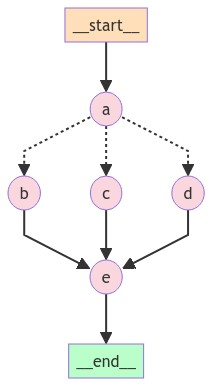

In [6]:
import * as tslab from "tslab";

const representation2 = graph2.getGraph();
const image2 = await representation2.drawMermaidPng();
const arrayBuffer2 = await image2.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer2));

In [7]:
// Invoke the graph
let g2result = await graph2.invoke({ aggregate: [], which: "bc" });
console.log("Result 1: ", g2result);

Adding I'm A to 
Adding I'm B to I'm A
Adding I'm C to I'm A
Adding I'm E to I'm A,I'm B,I'm C
Result 1:  { aggregate: [ "I'm A", "I'm B", "I'm C", "I'm E" ], which: 'bc' }


In [8]:
g2result = await graph2.invoke({ aggregate: [], which: "cd" });
console.log("Result 2: ", g2result);


Adding I'm A to 
Adding I'm C to I'm A
Adding I'm D to I'm A
Adding I'm E to I'm A,I'm C,I'm D


Result 2:  { aggregate: [ "I'm A", "I'm C", "I'm D", "I'm E" ], which: 'cd' }


## Stable Sorting

When fanned out, nodes are run in parallel as a single "superstep". The updates
from each superstep are all applied to the state in sequence once the superstep
has completed.

If you need consistent, predetermined ordering of updates from a parallel
superstep, you should write the outputs (along with an identifying key) to a
separate field in your state, then combine them in the "sink" node by adding
regular `edge`s from each of the fanout nodes to the rendezvous point.

For instance, suppose I want to order the outputs of the parallel step by
"reliability".


In [9]:
type ScoredValue = {
  value: string;
  score: number;
};

const reduceFanouts = (left?: ScoredValue[], right?: ScoredValue[]) => {
  if (!left) {
    left = [];
  }
  if (!right || right?.length === 0) {
    // Overwrite. Similar to redux.
    return [];
  }
  return left.concat(right);
};

const StableSortingAnnotation = Annotation.Root({
  aggregate: Annotation<string[]>({
    reducer: (x, y) => x.concat(y),
  }),
  which: Annotation<string>({
    reducer: (x: string, y: string) => (y ?? x),
  }),
  fanoutValues: Annotation<ScoredValue[]>({
    reducer: reduceFanouts,
  }),
})


class ParallelReturnNodeValue {
  private _value: string;
  private _score: number;

  constructor(nodeSecret: string, score: number) {
    this._value = nodeSecret;
    this._score = score;
  }

  public call(state: typeof StableSortingAnnotation.State) {
    console.log(`Adding ${this._value} to ${state.aggregate}`);
    return { fanoutValues: [{ value: this._value, score: this._score }] };
  }
}

// Create the graph

const nodeA3 = (state: typeof StableSortingAnnotation.State) => {
  console.log(`Adding I'm A to ${state.aggregate}`);
  return { aggregate: ["I'm A"] };
};

const nodeB3 = new ParallelReturnNodeValue("I'm B", 0.1);
const nodeC3 = new ParallelReturnNodeValue("I'm C", 0.9);
const nodeD3 = new ParallelReturnNodeValue("I'm D", 0.3);

const aggregateFanouts = (state: typeof StableSortingAnnotation.State) => {
  // Sort by score (reversed)
  state.fanoutValues.sort((a, b) => b.score - a.score);
  return {
    aggregate: state.fanoutValues.map((v) => v.value).concat(["I'm E"]),
    fanoutValues: [],
  };
};

// Define the route function
function routeBCOrCD(state: typeof StableSortingAnnotation.State): string[] {
  if (state.which === "cd") {
    return ["c", "d"];
  }
  return ["b", "c"];
}

const builder3 = new StateGraph(StableSortingAnnotation)
  .addNode("a", nodeA3)
  .addEdge(START, "a")
  .addNode("b", nodeB3.call.bind(nodeB3))
  .addNode("c", nodeC3.call.bind(nodeC3))
  .addNode("d", nodeD3.call.bind(nodeD3))
  .addNode("e", aggregateFanouts)
  .addConditionalEdges("a", routeBCOrCD, ["b", "c", "d"])
  .addEdge("b", "e")
  .addEdge("c", "e")
  .addEdge("d", "e")
  .addEdge("e", END);

const graph3 = builder3.compile();

// Invoke the graph
let g3result = await graph3.invoke({ aggregate: [], which: "bc" });
console.log("Result 1: ", g3result);


Adding I'm A to 
Adding I'm B to I'm A
Adding I'm C to I'm A
Result 1:  {
  aggregate: [ "I'm A", "I'm C", "I'm B", "I'm E" ],
  which: 'bc',
  fanoutValues: []
}


Our aggregateFanouts "sink" node in this case took the mapped values and then
sorted them in a consistent way. Notice that, because it returns an empty array
for `fanoutValues`, our `reduceFanouts` reducer function decided to overwrite
the previous values in the state.


In [10]:
let g3result2 = await graph3.invoke({ aggregate: [], which: "cd" });
console.log("Result 2: ", g3result2);


Adding I'm A to 
Adding I'm C to I'm A
Adding I'm D to I'm A
Result 2:  {
  aggregate: [ "I'm A", "I'm C", "I'm D", "I'm E" ],
  which: 'cd',
  fanoutValues: []
}
